In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
from sqlalchemy.sql import text
from tqdm.notebook import tqdm

plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# Compare values in RESA with those in AM

And update RESA to match AM where differences are found.

Used for both the "main" programme and the Bk-stations.

 * **Bk-stations:** Project 4591 in RESA; 12565 in AM
 * **Main rivers:** Project 4551 in RESA; 12564 in AM

In [3]:
# Set year and project IDs
year = 2021
resa_proj_id = 4551
am_proj_id = 12564

# Where to ignore sample time components. Can be useful, but use with caution -
# could cause issues if there are ever two genuine samples from the same location
# on the same day
ignore_times = False

In [4]:
def extract_flags(value):
    if value.startswith("<"):
        return "<"
    elif value.startswith(">"):
        return ">"
    else:
        return np.nan

In [5]:
# Pars to consider
# NOTE: This notebook ONLY checks the parameters in the dict below.
# Add rows to this dict mapping AM parameter names to RESA parameters names
# to inlcude more parameters
all_pars_dict = {
    "Ag_µg/L": "Ag_µg/l",
    "Alk_4.5_mmol/l": "ALK_mmol/l",
    "As_µg/l": "As_µg/l",
    "As-filt_µg/l": "As (filtrert)_µg/l",
    "Ca_mg/L": "Ca_mg/l",
    "Cd-filt_µg/l": "Cd (filtrert)_µg/l",
    "Cd_µg/l": "Cd_µg/l",
    "Cl_mg/L": "Cl_mg/l",
    "Cr_µg/l": "Cr_µg/l",
    "Cr-filt_µg/l": "Cr (filtrert)_µg/l",
    "Cu_µg/L": "Cu_µg/l",
    "Cu-filt_µg/l": "Cu (filtrert)_µg/l",
    "DOC_mg/L C": "DOC_mg/L C",
    "Farge_mg Pt/l": "FARGE_mg Pt/l",
    "Hg-filt_ng/l": "Hg (filtrert)_ng/l",
    "Hg_ng/l": "Hg_ng/l",
    "K_mg/L": "K_mg/l",
    "Konduktivitet_mS/m": "KOND_mS/m",
    "Mg_mg/L": "Mg_mg/l",
    "NH4-N_µg/l": "NH4-N_µg/l N",
    "NO3-N_µg/l": "NO3-N_µg/l N",
    "Na_mg/L": "Na_mg/l",
    "Ni-filt_µg/l": "Ni (filtrert)_µg/l",
    "Ni_µg/L": "Ni_µg/l",
    "Nitrogen part_µg/l N": "Tot. Part. N_µg/l N",
    "PO4-P_µg/l": "PO4-P_µg/l P",
    "POC_µg/l C": "Part. C_µg/l C",
    "Pb-filt_µg/l": "Pb (filtrert)_µg/l",
    "Pb_µg/L": "Pb_µg/l",
    "SO4_mg/L": "SO4_mg/l",
    "STS_mg/l": "STS_mg/l",
    "SiO2_mg/l": "SiO2_mg SiO2/l",
    "Si_mg/l": "Si_mg/l",
    "TOC_mg/l": "TOC_mg C/l",
    "TOTN_µg/l": "TOTN_µg/l N",
    "TOTP_P_µg/l P": "TOTP/P_µg/l",
    "TOTP_µg/l": "TOTP_µg/l P",
    "TSM_mg/l": "SPM_mg/l",
    "Temperatur_C": "Temp_oC",
    "Turbiditet_FNU": "TURB860_FNU",
    "Zn_µg/l": "Zn_µg/l",
    "pH_": "pH_",
}

In [6]:
# Get data from RESA
resa_stn_df = nivapy.da.select_resa_project_stations([resa_proj_id], eng)
resa_par_df = nivapy.da.select_resa_station_parameters(
    resa_stn_df, f"{year}-01-01", f"{year}-12-31", eng
)
resa_wc_df, resa_dup_df = nivapy.da.select_resa_water_chemistry(
    resa_stn_df,
    resa_par_df,
    f"{year}-01-01",
    f"{year}-12-31",
    eng,
    lod_flags=True,
    drop_dups=True,
)

# Convert to long
id_vars = [
    "station_id",
    "station_code",
    "station_name",
    "sample_date",
    "depth1",
    "depth2",
]
resa_wc_df = resa_wc_df.melt(id_vars=id_vars, value_name="resa_value")
resa_wc_df.dropna(subset="resa_value", inplace=True)

# Extract flags
resa_wc_df["flag1"] = resa_wc_df["resa_value"].apply(extract_flags)
resa_wc_df["resa_value"] = (
    resa_wc_df["resa_value"].str.replace("<", "").replace(">", "").astype(float)
)

# Ignore time component?
if ignore_times:
    resa_wc_df["sample_date"] = resa_wc_df["sample_date"].dt.date

40 parameters available for the selected stations and dates.
WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



In [7]:
# Get data from AM
am_stn_df = nivapy.da.select_ndb_project_stations([am_proj_id], eng)
am_par_df = nivapy.da.select_ndb_station_parameters(
    am_stn_df, f"{year}-01-01", f"{year}-12-31", eng
)
am_wc_df, am_dup_df = nivapy.da.select_ndb_water_chemistry(
    am_stn_df,
    am_par_df,
    f"{year}-01-01",
    f"{year}-12-31",
    eng,
    lod_flags=True,
    drop_dups=True,
)

# Rename to match RESA
am_wc_df.rename(
    all_pars_dict,
    axis="columns",
    inplace=True,
)

# Convert to long
id_vars = [
    "station_id",
    "station_code",
    "station_name",
    "sample_date",
    "depth1",
    "depth2",
]
am_wc_df = am_wc_df.melt(id_vars=id_vars, value_name="am_value")
am_wc_df.dropna(subset="am_value", inplace=True)

# Extract flags
am_wc_df["flag1"] = am_wc_df["am_value"].apply(extract_flags)
am_wc_df["am_value"] = (
    am_wc_df["am_value"].str.replace("<", "").replace(">", "").astype(float)
)

# Ignore time component?
if ignore_times:
    am_wc_df["sample_date"] = am_wc_df["sample_date"].dt.date

73 parameters available for the selected stations and dates.


In [8]:
# Link stations in AM and RESA
bind_pars = ",".join("%d" % i for i in am_wc_df["station_id"].unique())
sql = text(
    "SELECT station_id as am_station_id, "
    "  local_pk as resa_station_id "
    "FROM nivadatabase.datasource_station "
    "WHERE datasource_id = 11 "
    "AND station_id IN (%s)" % bind_pars
)
link_df = pd.read_sql(sql, eng)
len(link_df)

20

In [9]:
# Combine
df = pd.merge(
    resa_wc_df, link_df, how="left", left_on="station_id", right_on="resa_station_id"
)
df = pd.merge(
    df,
    am_wc_df,
    how="left",
    left_on=["am_station_id", "sample_date", "depth1", "depth2", "variable"],
    right_on=["station_id", "sample_date", "depth1", "depth2", "variable"],
    suffixes=["_resa", "_am"],
)

print(len(df), "values in this project and period.")
print(len(df.query("am_value == resa_value")), "values are idenitcal.")
print(pd.isna(df["am_value"]).sum(), "values in RESA cannot be identified in AM.")
print(
    len(df.dropna(subset="am_value").query("resa_value != am_value")),
    "values in AM are different to those in RESA.",
)

df.head()

7100 values in this project and period.
7099 values are idenitcal.
1 values in RESA cannot be identified in AM.
0 values in AM are different to those in RESA.


,station_id_resa,station_code_resa,station_name_resa,sample_date,depth1,depth2,variable,resa_value,flag1_resa,am_station_id,resa_station_id,station_id_am,station_code_am,station_name_am,am_value,flag1_am
0,29612,BUSEDRA,Drammenselva,2021-01-21 10:30:00,0,0,ALK_mmol/l,0.205,NaN,40352,29612,40352.0,DRA1,Drammenselva v/Krokstadelva,0.205,NaN
1,29612,BUSEDRA,Drammenselva,2021-02-02 15:00:00,0,0,ALK_mmol/l,0.219,NaN,40352,29612,40352.0,DRA1,Drammenselva v/Krokstadelva,0.219,NaN
2,29612,BUSEDRA,Drammenselva,2021-03-02 08:30:00,0,0,ALK_mmol/l,0.237,NaN,40352,29612,40352.0,DRA1,Drammenselva v/Krokstadelva,0.237,NaN
3,29612,BUSEDRA,Drammenselva,2021-04-06 11:30:00,0,0,ALK_mmol/l,0.209,NaN,40352,29612,40352.0,DRA1,Drammenselva v/Krokstadelva,0.209,NaN
4,29612,BUSEDRA,Drammenselva,2021-05-03 09:00:00,0,0,ALK_mmol/l,0.181,NaN,40352,29612,40352.0,DRA1,Drammenselva v/Krokstadelva,0.181,NaN


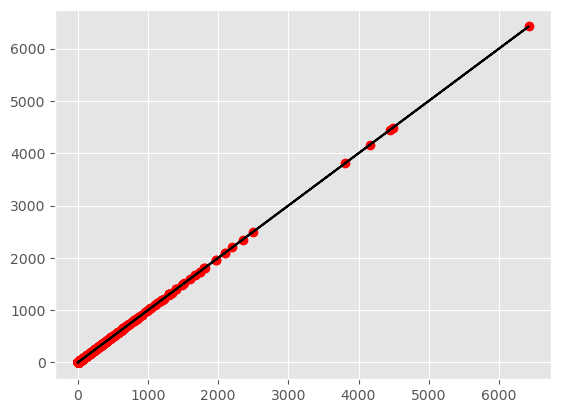

In [10]:
# Compare
plt.plot(df["resa_value"], df["am_value"], "ro")
plt.plot(df["resa_value"], df["resa_value"], "k-")

## Update RESA to match AM

There were originally 15 values to update.

In [11]:
cor_df = df.dropna(subset="am_value").query("resa_value != am_value")
print(len(cor_df))
cor_df

0


,station_id_resa,station_code_resa,station_name_resa,sample_date,depth1,depth2,variable,resa_value,flag1_resa,am_station_id,resa_station_id,station_id_am,station_code_am,station_name_am,am_value,flag1_am


In [12]:
# # Update RESA
# for idx, row in tqdm(cor_df.iterrows(), total=cor_df.shape[0]):
#     # Check unique record can be identified
#     sql = text(
#         "SELECT * FROM resa2.water_chemistry_values2 "
#         "WHERE sample_id IN ( "
#         "  SELECT water_sample_id FROM resa2.water_samples "
#         "  WHERE station_id = :stn_id "
#         "  AND sample_date = :samp_date "
#         "  AND depth1 = :depth1 "
#         "  AND depth2 = :depth2 "
#         ") "
#         "AND value = :resa_value"
#     )
#     check_df = pd.read_sql(
#         sql,
#         eng,
#         params={
#             "stn_id": row["resa_station_id"],
#             "samp_date": row["sample_date"],
#             "depth1": row["depth1"],
#             "depth2": row["depth2"],
#             "resa_value": row["resa_value"],
#         },
#     )
#     assert len(check_df) == 1, check_df

#     # Update RESA
#     if pd.isna(row["flag1_am"]):
#         flag = None

#     sql = text(
#         "UPDATE resa2.water_chemistry_values2 "
#         "SET flag1 = :flag, "
#         "  value = :value "
#         "WHERE sample_id IN ( "
#         "  SELECT water_sample_id FROM resa2.water_samples "
#         "  WHERE station_id = :stn_id "
#         "  AND sample_date = :samp_date "
#         "  AND depth1 = :depth1 "
#         "  AND depth2 = :depth2 "
#         ") "
#         "AND value = :resa_value"
#     )
#     eng.execute(
#         sql,
#         {
#             "flag": flag,
#             "value": row["am_value"],
#             "stn_id": row["resa_station_id"],
#             "samp_date": row["sample_date"],
#             "depth1": row["depth1"],
#             "depth2": row["depth2"],
#             "resa_value": row["resa_value"],
#         },
#     )

## Samples in RESA but not AM

In [13]:
df2 = df[pd.isna(df["am_value"])].sort_values(["station_code_resa", "sample_date"])
df2

,station_id_resa,station_code_resa,station_name_resa,sample_date,depth1,depth2,variable,resa_value,flag1_resa,am_station_id,resa_station_id,station_id_am,station_code_am,station_name_am,am_value,flag1_am
6773,29842,SFJENAU,Nausta,2021-02-22 11:00:00,0,0,VANNST_???,0.2,NaN,40391,29842,NaN,NaN,NaN,NaN,NaN


In [14]:
for grp in df2.groupby(["station_code_resa", "sample_date"]).groups:
    print(grp)

('SFJENAU', Timestamp('2021-02-22 11:00:00'))
